# Demo of main features of Fatiando a Terra

In [28]:
from __future__ import division, print_function
from future.builtins import super
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('font', size=12)

In [3]:
from fatiando.mesher import Prism
modelo = [Prism(0, 1000, 0, 2000, 1500, 2500, 
                props={'magnetization': [4, -1, 3]})]

In [4]:
from fatiando.vis import myv

In [10]:
myv.figure(size=(600, 600))
myv.prisms(modelo)
myv.savefig('../figures/fatiando-demo-prism.png')
myv.show()

In [5]:
from fatiando import gridder
area = (-5000, 5000, -5000, 5000)
shape = (50, 50)
x, y, z = gridder.regular(area, shape, z=0)
print(x)
print(x.size)

[-5000. -5000. -5000. ...,  5000.  5000.  5000.]
2500


/home/leo/bin/anaconda/envs/phd/lib/python2.7/site-packages/matplotlib/tri/triangulation.py:110: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  self._neighbors)


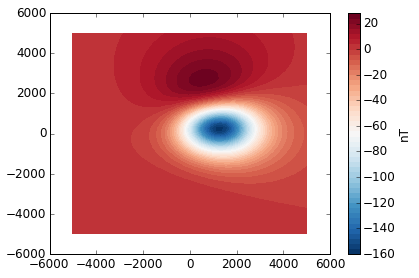

In [6]:
from fatiando.gravmag import prism
mag = prism.tf(x, y, z, modelo, inc=-60, dec=20)

import matplotlib.pyplot as plt
plt.tricontourf(y, x, mag, 50, cmap="RdBu_r")
plt.colorbar().set_label('nT')
plt.tight_layout()
plt.savefig('../figures/fatiando-demo-tf.png', dpi=300)

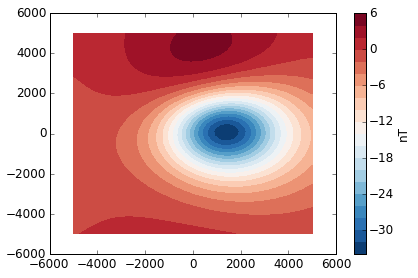

In [7]:
from fatiando.gravmag import transform
up = transform.upcontinue(x, y, mag, shape, 1500)

plt.tricontourf(y, x, up, 20, cmap="RdBu_r")
plt.colorbar().set_label('nT')
plt.tight_layout()
plt.savefig('../figures/fatiando-demo-upcontinue.png', dpi=300)

In [8]:
from fatiando.mesher import Tesseroid
mod = [Tesseroid(-60, -50, -25, -20, 2000, 0,
                 props={'density': 2670})]

scene = myv.figure(size=(600, 600))
myv.tesseroids(mod, scale=(1, 1, 500))
myv.earth()
myv.continents()
scene.scene.camera.position = [6616119.255603333, -18971761.61753707, -4748375.7432072889]
scene.scene.camera.focal_point = [552780.74208198907, -352807.90531539323, -1245581.9718509372]
scene.scene.camera.view_angle = 30.0
scene.scene.camera.view_up = [0.17484124125758407, -0.12675357588723518, 0.97640364161309157]
scene.scene.camera.clipping_range = [2451763.22076324, 43517730.742070638]
scene.scene.camera.compute_view_plane_normal()
scene.scene.render()
myv.savefig('../figures/fatiando-demo-tesseroid.png')
myv.show()

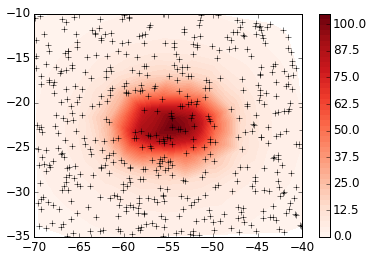

In [9]:
lon, lat, h = gridder.scatter(
    (-70, -40, -35, -10), 500, z=250e3)

from fatiando.gravmag import tesseroid
g = tesseroid.gz(lon, lat, h, mod)

plt.tricontourf(lon, lat, g, 50, cmap="Reds")
plt.colorbar()
plt.plot(lon, lat, 'k+')
plt.savefig('../figures/fatiando-demo-grav.png', dpi=300)

# fatiando.inversion

In [10]:
import numpy as np

In [93]:
x = np.linspace(0, 100, 100)
y = 20*x + 5000

In [94]:
from fatiando import utils

In [122]:
yo = utils.contaminate(y, 0.02, percent=True)

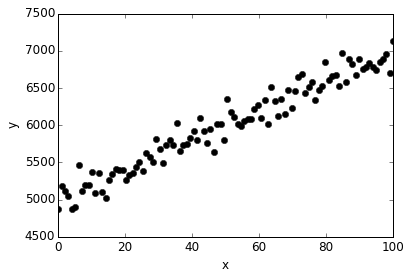

In [123]:
plt.plot(x, yo, 'ok')
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('../figures/fatiando-demo-line-data.png', dpi=300, transparent=True)

In [124]:
from fatiando.inversion import Misfit

class Regressao(Misfit):
    def __init__(self, x, y):
        Misfit.__init__(self, 
            data=y, nparams=2, islinear=True)
        self.x = x
    def predicted(self, p):
        a, b = p
        return a*self.x + b
    def jacobian(self, p):
        A = np.empty((self.ndata, self.nparams))
        A[:, 0] = self.x
        A[:, 1] = 1
        return A        

In [125]:
reg = Regressao(x, yo)
reg.fit()
print(reg.estimate_)

[   19.81835288  5009.08235609]


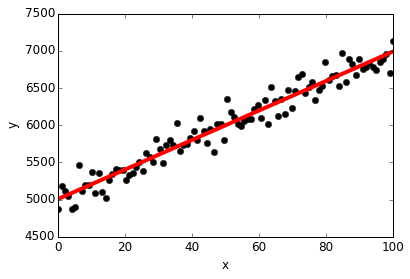

In [126]:
plt.plot(x, yo, 'ok')
plt.plot(x, reg.predicted(), '-r', linewidth=4)
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('../figures/fatiando-demo-inv-line.png', dpi=300)

In [127]:
reg.config('newton', initial=[1, 1]).fit()
print(reg.estimate_)

[   19.81835288  5009.08235609]


In [128]:
reg.config('levmarq', initial=[0, 0]).fit()
print(reg.estimate_)

[   19.81855074  5009.0709035 ]


In [129]:
reg.config('acor', 
           bounds=[0, 1000, 0, 10e5]).fit()
print(reg.estimate_)

[   19.81835284  5009.08235779]


In [130]:
from fatiando.inversion import Damping
phi = Regressao(x, yo)
gamma = phi + 10e-7*Damping(nparams=2)

In [131]:
gamma.fit()
print(gamma.estimate_)

[   19.81835582  5009.08215872]


In [132]:
gamma.config('acor', 
             bounds=[0, 1000, 0, 10e5]).fit()
print(gamma.estimate_)

[   20.14654754  4992.15040076]


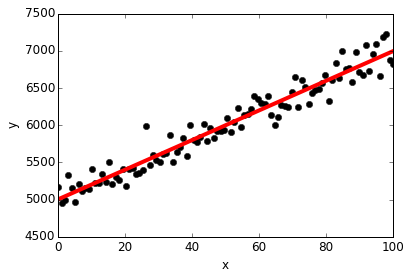

In [110]:
plt.plot(x, yo, 'ok')
plt.plot(x, gamma[0].predicted(), '-r', linewidth=4)
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('../figures/fatiando-demo-inv-regul.png', dpi=300)